In [14]:
import os
import cv2
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import (
    SelectKBest, 
    f_classif,  # ANOVA F-value between label/feature
    mutual_info_classif  # Mutual information
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, MaxPooling1D, GRU, TimeDistributed, Flatten ,Conv2D, Conv3D, MaxPooling3D, BatchNormalization, Reshape, Lambda, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.7.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
beautifulsoup4               4.12.3
bleach                       6.2.0
cachetools                   5.5.0
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.4.0
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.9
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.2
executing                    2.1.0
fastjsonschema               2.21


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Paths and constants
DATA_PATH = 'DATA'  # Path to save videos and keypoints
# DATA_PATH = 'NEW_DATA'  # Path to save new videos and keypoints for adding new data
# accumulated actions
ACTIONS = np.array(['Hi', 'Saya Sayang Awak', 'Makan',
                   'Selamat Malam', 'Terima Kasih', 'Apa Khabar',
                   'Awak', 'Saya', 'Minum',
                   'Salah', 'Betul', 'Minta Maaf',
                   'Tolong', 'Hijau', 'Kita',
                   'Mereka', 'Ini', 'Itu',
                   'Apa', 'Siapa',
                    'Ini Di Luar Pengetahuan Saya'
                   ])

# new actions to be added to the dataset
# ACTIONS = np.array(['Ini Di Luar Pengetahuan Saya'])

OLD_ACTIONS = np.array(['Hi', 'Saya Sayang Awak', 'Makan'])
NEW_ACTIONS = np.array(['Selamat Malam', 'Terima Kasih', 'Apa Khabar'])


NO_SEQUENCES = 90  # Number of videos per action
SEQUENCE_LENGTH = 90  # Frames per video

In [7]:
def record_videos():
    # default will record 30 video
    # start_sequence = 0
    # last_sequence = 30
    start_sequence = 30
    last_sequence = 90
    os.makedirs(DATA_PATH, exist_ok=True)
    for action in ACTIONS:
        os.makedirs(os.path.join(DATA_PATH, action), exist_ok=True)

    cap = cv2.VideoCapture(0)
    frame_rate = 30  # Frames per second
    video_duration = 3  # Duration in seconds
    total_frames = frame_rate * video_duration
    
    for action in ACTIONS:
        print(f"Recording for action: {action}")
        for sequence in range(start_sequence, last_sequence):
            video_path = os.path.join(DATA_PATH, action, f"{sequence}.mp4")
            out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (640, 480))

            print(f"Starting sequence {sequence+1}/{last_sequence} in 2 seconds...")
            time.sleep(2)  # Add a 2-second delay before recording starts

            for frame_num in range(total_frames):
                ret, frame = cap.read()
                if not ret:
                    print("Failed to capture frame.")
                    break

                # Display recording information
                cv2.rectangle(frame, (0,0), (640, 60), (255, 255, 255), -1)
                cv2.putText(frame, f"Recording {action}: Video {sequence+1}/{last_sequence}", 
                            (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (14, 14, 14), 2)
                cv2.imshow("Recording", frame)

                out.write(frame)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    print("Recording interrupted.")
                    break

            out.release()

    cap.release()
    cv2.destroyAllWindows()

In [8]:
#collect videos as dataset
record_videos()

Recording for action: Ini Di Luar Pengetahuan Saya
Starting sequence 31/90 in 2 seconds...
Starting sequence 32/90 in 2 seconds...
Starting sequence 33/90 in 2 seconds...
Starting sequence 34/90 in 2 seconds...
Starting sequence 35/90 in 2 seconds...
Starting sequence 36/90 in 2 seconds...
Starting sequence 37/90 in 2 seconds...
Starting sequence 38/90 in 2 seconds...
Starting sequence 39/90 in 2 seconds...
Starting sequence 40/90 in 2 seconds...
Starting sequence 41/90 in 2 seconds...
Starting sequence 42/90 in 2 seconds...
Starting sequence 43/90 in 2 seconds...
Starting sequence 44/90 in 2 seconds...
Starting sequence 45/90 in 2 seconds...
Starting sequence 46/90 in 2 seconds...
Starting sequence 47/90 in 2 seconds...
Starting sequence 48/90 in 2 seconds...
Starting sequence 49/90 in 2 seconds...
Starting sequence 50/90 in 2 seconds...
Starting sequence 51/90 in 2 seconds...
Starting sequence 52/90 in 2 seconds...
Starting sequence 53/90 in 2 seconds...
Starting sequence 54/90 in 2 

In [74]:
cap.release()
cv2.destroyAllWindows()

NameError: name 'cap' is not defined

In [11]:
# Visualize the keypoints in numpy array, so that we validate whether the keypoints are correct
import numpy as np
import cv2
import os

# Define Mediapipe connections (assumes 33 keypoints)
# Updated connections to include only pose, left hand, and right hand
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Upper body
    (0, 4), (4, 5), (5, 6), (6, 8),  # Upper body
    (9, 10),  # Neck
    (11, 12), (11, 13), (13, 15), (15, 17),  # Left side
    (12, 14), (14, 16), (16, 18)  # Right side
]

HAND_CONNECTIONS = [
    # Connections for fingers (same for both hands)
    (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
    (5, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
    (9, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
    (13, 17), (17, 18), (18, 19), (19, 20)  # Pinky
]


def visualize_extracted_keypoints(keypoints, action_name, frame_idx):
    """
    Visualize extracted keypoints (pose, left hand, right hand).

    :param keypoints: Numpy array of shape (num_keypoints,)
                      Includes pose (33*4), left hand (21*3), right hand (21*3).
    :param action_name: String, action name
    :param frame_idx: Integer, current frame index for labeling
    """
    canvas = np.ones((480, 640, 3), dtype=np.uint8) * 255  # Blank white canvas

    # Extract pose, left hand, and right hand keypoints
    pose = keypoints[:33 * 4].reshape((33, 4))[:, :2] * [640, 480]  # Normalize to image size
    lh = keypoints[33 * 4:33 * 4 + 21 * 3].reshape((21, 3))[:, :2] * [640, 480]
    rh = keypoints[33 * 4 + 21 * 3:].reshape((21, 3))[:, :2] * [640, 480]

    # Draw pose connections
    for start, end in POSE_CONNECTIONS:
        x1, y1 = pose[start]
        x2, y2 = pose[end]
        cv2.line(canvas, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    for x, y in pose:
        cv2.circle(canvas, (int(x), int(y)), 5, (0, 0, 255), -1)

    # Draw left hand connections
    for start, end in HAND_CONNECTIONS:
        if start < len(lh) and end < len(lh):
            x1, y1 = lh[start]
            x2, y2 = lh[end]
            cv2.line(canvas, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    for x, y in lh:
        cv2.circle(canvas, (int(x), int(y)), 5, (0, 0, 255), -1)

    # Draw right hand connections
    for start, end in HAND_CONNECTIONS:
        if start < len(rh) and end < len(rh):
            x1, y1 = rh[start]
            x2, y2 = rh[end]
            cv2.line(canvas, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
    for x, y in rh:
        cv2.circle(canvas, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Add action label and frame info
    cv2.putText(canvas, f"Frame: {frame_idx}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Display the canvas
    cv2.imshow("Extracted Keypoint Visualization", canvas)
    cv2.waitKey(50)  # Adjust delay between frames

# Load extracted keypoints
keypoints_data = np.load(f"{DATA_PATH}/Ini Di Luar Pengetahuan Saya/60.npy")  # Shape (NUM_SEQUENCES, SEQUENCE_LENGTH, num_keypoints)
SEQUENCE_LENGTH = 90  # Adjust based on your actual data
NUM_KEYPOINTS = 258
reshaped_data = keypoints_data.reshape(-1, SEQUENCE_LENGTH, NUM_KEYPOINTS)

for sequence_idx, sequence in enumerate(reshaped_data):
    for frame_idx, keypoints in enumerate(sequence):
        # Reshape and normalize keypoints for visualization
        pose = keypoints[:33 * 4].reshape((33, 4))[:, :2] * [640, 480]  # Pose keypoints
        lh = keypoints[33 * 4:33 * 4 + 21 * 3].reshape((21, 3))[:, :2] * [640, 480]  # Left hand
        rh = keypoints[33 * 4 + 21 * 3:].reshape((21, 3))[:, :2] * [640, 480]  # Right hand

        visualize_extracted_keypoints(keypoints, f"Action_{sequence_idx}", frame_idx)

cv2.destroyAllWindows()

In [3]:
# Mediapipe setup
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    return image, results

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)
    return np.concatenate([pose, lh, rh])

def extract_keypoints_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints = []
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            _, results = mediapipe_detection(frame, holistic)
            keypoint_frame = extract_keypoints(results)
            keypoints.append(keypoint_frame)

    cap.release()
    return np.array(keypoints)

def process_videos_to_keypoints(start_sequence=0, end_sequence=None):
    """
    Process videos to extract keypoints and save as .npy files,
    keeping .npy indices aligned with video indices.
    """
    for action in ACTIONS:
        action_path = os.path.join(DATA_PATH, action)
        
        # Get all video files in the action directory
        video_files = [f for f in os.listdir(action_path) if f.endswith(".mp4")]
        
        # Sort files numerically based on the numeric part of their names
        video_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
        
        # If end_index is None, process all files from start_index onwards
        if end_sequence is None:
            end_sequence = len(video_files)
        
        for video_file in video_files[start_sequence:end_sequence]:
            # Extract the numeric index from the video filename
            video_index = int(''.join(filter(str.isdigit, os.path.splitext(video_file)[0])) or 0)
            
            video_path = os.path.join(action_path, video_file)
            keypoints = extract_keypoints_from_video(video_path)
            
            # Save keypoints as .npy, ensuring consistent zero-based naming
            npy_path = os.path.join(action_path, f"{video_index}.npy")
            np.save(npy_path, keypoints)
            print(f"Processed and saved keypoints for Action({action}) {video_file} as {video_index}.npy")


In [10]:
# Process sequences from index (start_sequence) to (end_sequence-not inclusive) for all actions
process_videos_to_keypoints(start_sequence=0, end_sequence=90)

Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 0.mp4 as 0.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 1.mp4 as 1.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 2.mp4 as 2.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 3.mp4 as 3.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 4.mp4 as 4.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 5.mp4 as 5.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 6.mp4 as 6.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 7.mp4 as 7.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 8.mp4 as 8.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 9.mp4 as 9.npy
Processed and saved keypoints for Action(Ini Di Luar Pengetahuan Saya) 10.mp4 as 10.npy
Processed and saved keypoints for Action(Ini Di Luar

In [4]:
def load_data():
    sequences, labels = [], []
    label_map = {action: idx for idx, action in enumerate(ACTIONS)}

    for action in ACTIONS:
        for sequence in range(NO_SEQUENCES):
            npy_path = os.path.join(DATA_PATH, action, f"{sequence}.npy")
            keypoints = np.load(npy_path)
            sequences.append(keypoints)
            labels.append(label_map[action])

    x = np.array(sequences)
    y = to_categorical(labels, num_classes=len(ACTIONS))
    return x, y

x, y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Train Data:{x_train.shape} Test Data:{y_test.shape}")
#Improve Input Data Preprocessing 
#Normalize your data
#Check and augment data: Ensure your dataset has balanced classes. If not, augment the data for underrepresented classes by duplicating sequences or introducing slight noise to the sequences.

scaler = MinMaxScaler()
x_train_flat = x_train.reshape(-1, x_train.shape[-1])  # Flatten for scaling
x_test_flat = x_test.reshape(-1, x_test.shape[-1])

x_train_scaled = scaler.fit_transform(x_train_flat).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test_flat).reshape(x_test.shape)
print(f"After Preprocessing => Train Data:{x_train_scaled.shape} Test Data:{x_test_scaled.shape}")

Train Data:(1323, 90, 258) Test Data:(567, 21)
After Preprocessing => Train Data:(1323, 90, 258) Test Data:(567, 90, 258)


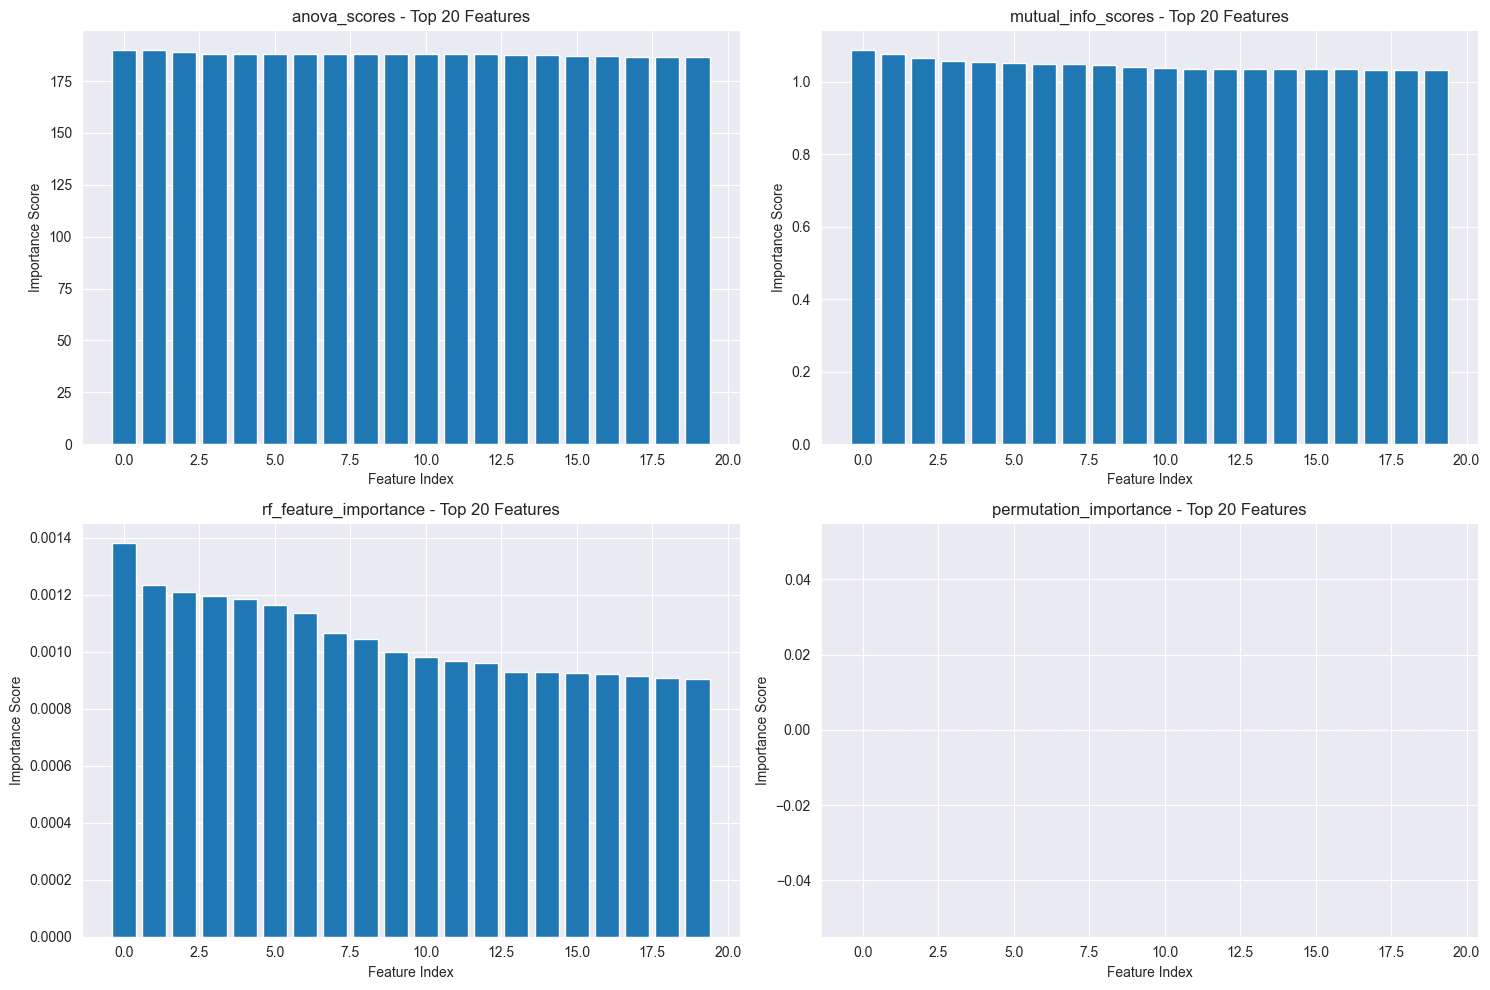

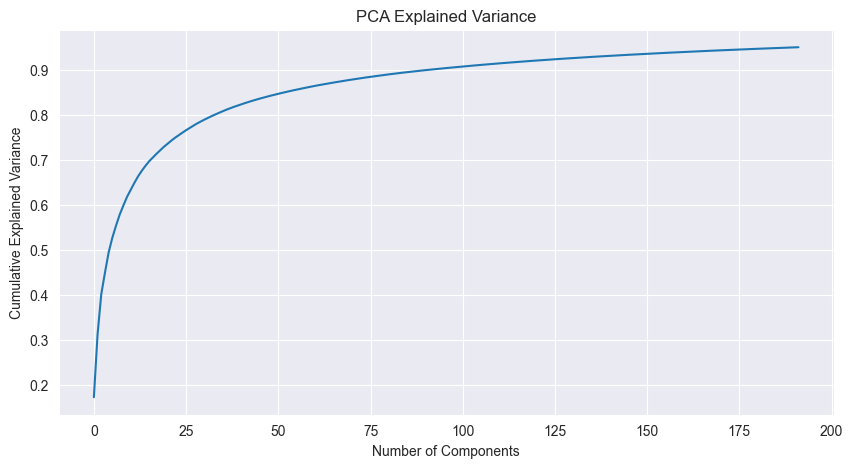

Original shape: (1323, 23220)
Reduced shape: (1323, 192)
Variance explained: 95.01%


In [18]:
#dimensionality reduction
def feature_ranking_methods(X, y):
    """
    Multiple feature ranking techniques
    
    Args:
    - X: Input features (2D numpy array)
    - y: Labels (1D numpy array)
    
    Returns:
    - Dictionary of feature ranking results
    """
    results = {}
    
    # Reshape input if necessary
    if len(X.shape) > 2:
        X_flat = X.reshape(X.shape[0], -1)
    else:
        X_flat = X
    
    # 1. ANOVA F-test Feature Selection
    selector_f = SelectKBest(score_func=f_classif, k='all')
    selector_f.fit(X_flat, np.argmax(y, axis=1))
    results['anova_scores'] = selector_f.scores_
    
    # 2. Mutual Information Feature Selection
    selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
    selector_mi.fit(X_flat, np.argmax(y, axis=1))
    results['mutual_info_scores'] = selector_mi.scores_
    
    # 3. Random Forest Feature Importance
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_flat, np.argmax(y, axis=1))
    results['rf_feature_importance'] = rf_classifier.feature_importances_
    
    # 4. Permutation Importance
    perm_importance = permutation_importance(
        rf_classifier, X_flat, np.argmax(y, axis=1), 
        n_repeats=10, random_state=42
    )
    results['permutation_importance'] = perm_importance.importances_mean
    
    return results

def visualize_feature_importance(importance_results, num_top_features=20):
    """
    Visualize feature importance from different methods
    
    Args:
    - importance_results: Dictionary of feature importance scores
    - num_top_features: Number of top features to visualize
    """
    plt.figure(figsize=(15, 10))
    
    methods = list(importance_results.keys())
    for i, (method, scores) in enumerate(importance_results.items(), 1):
        plt.subplot(2, 2, i)
        
        # Sort and select top features
        sorted_indices = np.argsort(scores)[::-1]
        top_scores = scores[sorted_indices[:num_top_features]]
        
        plt.bar(range(len(top_scores)), top_scores)
        plt.title(f'{method} - Top {num_top_features} Features')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance Score')
        plt.tight_layout()
    
    plt.show()

def dimensionality_reduction(X, y, n_components=0.95):
    """
    Apply PCA for dimensionality reduction
    
    Args:
    - X: Input features
    - y: Labels
    - n_components: Number of components or variance explained
    
    Returns:
    - Reduced dataset, PCA object
    """
    # Reshape if necessary
    if len(X.shape) > 2:
        X_flat = X.reshape(X.shape[0], -1)
    else:
        X_flat = X
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)
    
    # Visualization of explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.show()
    
    print(f"Original shape: {X_flat.shape}")
    print(f"Reduced shape: {X_reduced.shape}")
    print(f"Variance explained: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")
    
    return X_reduced, pca

# Example Usage
def main(x_train_scaled, y_train):
    # Feature Ranking
    importance_results = feature_ranking_methods(x_train_scaled, y_train)
    
    # Visualize Feature Importance
    visualize_feature_importance(importance_results)
    
    # Dimensionality Reduction
    x_train_reduced, pca = dimensionality_reduction(x_train_scaled, y_train)
    
    return x_train_reduced, importance_results, pca

# Uncomment and adapt when using
x_train_reduced, importance_results, pca = main(x_train_scaled, y_train)

In [33]:
#LSTM
def build_model(input_shape, output_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape)))
    model.add(LSTM(128, return_sequences=True, activation='tanh'))
    model.add(LSTM(128, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

model = build_model((SEQUENCE_LENGTH, x_train_scaled.shape[2]), len(ACTIONS))
model.summary()

history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_test_scaled, y_test),
    epochs=60,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 128)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,886 (1.35 MB)

 Trainable params: 354,886 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - categorical_accuracy: 0.2239 - loss: 3.8723 - val_categorical_accuracy: 0.3333 - val_loss: 3.6016
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - categorical_accuracy: 0.4157 - loss: 3.5243 - val_categorical_accuracy: 0.5741 - val_loss: 3.1380
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - categorical_accuracy: 0.4991 - loss: 3.0864 - val_categorical_accuracy: 0.6852 - val_loss: 2.7285
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - categorical_accuracy: 0.6326 - loss: 2.7076 - val_categorical_accuracy: 0.6420 - val_loss: 2.4885
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - categorical_accuracy: 0.7239 - loss: 2.4111 - val_categorical_accuracy: 0.7469 - val_loss: 2.2374
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - categorical_accuracy: 0.7192 - loss: 2.2408 - val_categorical_accuracy: 0.8086 - val_loss: 2.0304
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - categorical_accuracy: 0.7440 - loss: 2.12

In [33]:
#Old CNN + LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, LSTM, Dense

# Build the CNN + LSTM Model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # 1D Convolutional Layers for Feature Extraction
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM Layers for Temporal Dependencies
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))

    # Fully Connected Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output Layer with Softmax Activation for Multi-class Classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the Model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Build the model
input_shape = (SEQUENCE_LENGTH, x.shape[2])  # Replace `1662` with the actual feature dimension if needed
num_classes = len(ACTIONS)  # Number of action classes
model = build_cnn_lstm_model(input_shape, num_classes)

# Display model summary
model.summary()

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=110,
    batch_size=32
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 48, 64)            49600     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 24, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 12, 128)           0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 12, 128)          

ValueError: in user code:

    File "D:\Workshop 2 Project\action_recognition_model\.condaenv\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "D:\Workshop 2 Project\action_recognition_model\.condaenv\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Workshop 2 Project\action_recognition_model\.condaenv\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "D:\Workshop 2 Project\action_recognition_model\.condaenv\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "D:\Workshop 2 Project\action_recognition_model\.condaenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Workshop 2 Project\action_recognition_model\.condaenv\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 48, 258), found shape=(None, 90, 258)


In [ ]:
# Build New CNN + LSTM Model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # 1D Convolutional Layers for Feature Extraction
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM Layers for Temporal Dependencies
    model.add(LSTM(128, return_sequences=True, activation='tanh'))
    model.add(LSTM(64, return_sequences=False, activation='tanh'))

    # Fully Connected Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output Layer with Softmax Activation for Multi-class Classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the Model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Build the model
input_shape = (SEQUENCE_LENGTH, x_train.shape[2])  # Replace `x_train.shape[2]` with the actual feature dimension if needed
num_classes = len(ACTIONS)  # Number of action classes
model = build_cnn_lstm_model(input_shape, num_classes)

# Display model summary
model.summary()

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

In [17]:
def build_tcn_model(input_shape, num_classes):
    model = Sequential()

    # Temporal Convolutions
    model.add(Input(shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))

    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Build the model
input_shape = (SEQUENCE_LENGTH, x_train.shape[2])  # Replace `x_train.shape[2]` with the actual feature dimension if needed
num_classes = len(ACTIONS)  # Number of action classes
model = build_tcn_model(input_shape, num_classes)

# Display model summary
model.summary()

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 90, 64)            49600     
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 128)           24704     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 45, 128)           0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 45, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 256)           98560     
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                           

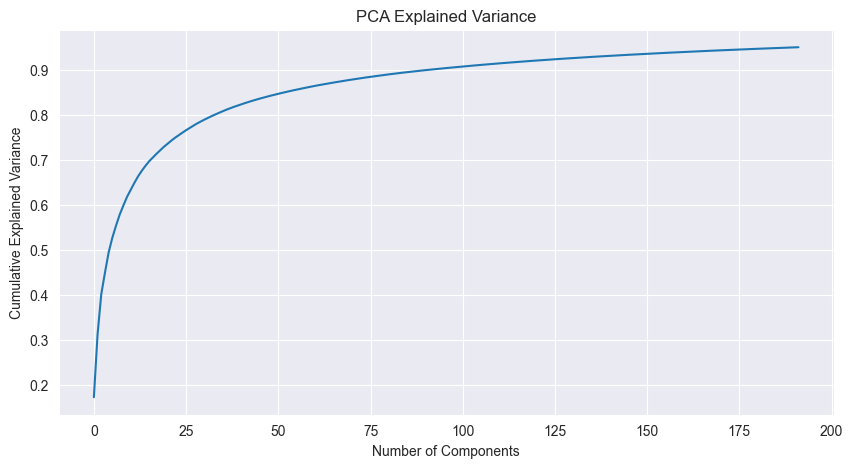

Original shape: (1323, 23220)
Reduced shape: (1323, 192)
Variance explained: 95.01%
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 48, 64)            832       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 24, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 24, 128)           24704     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 12, 128)           0         
 g1D)                                                            
                                    

In [35]:
# Dimensionality Reduction
x_train_flat = x_train_scaled.reshape(x_train_scaled.shape[0], -1)  # Flatten to 2D
x_train_reduced, pca = dimensionality_reduction(x_train_flat, y_train)

x_test_flat = x_test_scaled.reshape(x_test_scaled.shape[0], -1)  # Flatten to 2D
x_test_reduced = pca.transform(x_test_flat)

# Adjust sequence length
SEQUENCE_LENGTH = 48  # A divisor of 192
reduced_features_per_timestep = x_train_reduced.shape[1] // SEQUENCE_LENGTH

# Ensure the reduced features divide evenly by sequence length
if x_train_reduced.shape[1] % SEQUENCE_LENGTH != 0:
    raise ValueError("Reduced features do not evenly divide into the sequence length.")

x_train_seq = x_train_reduced.reshape(-1, SEQUENCE_LENGTH, reduced_features_per_timestep)
x_test_seq = x_test_reduced.reshape(-1, SEQUENCE_LENGTH, reduced_features_per_timestep)

# Update input shape for CNN-LSTM
input_shape = (SEQUENCE_LENGTH, reduced_features_per_timestep)

# Build New CNN + LSTM Model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # 1D Convolutional Layers for Feature Extraction
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM Layers for Temporal Dependencies
    model.add(LSTM(128, return_sequences=True, activation='tanh'))
    model.add(LSTM(64, return_sequences=False, activation='tanh'))

    # Fully Connected Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output Layer with Softmax Activation for Multi-class Classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the Model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Build the model
num_classes = len(ACTIONS)  # Number of action classes
model = build_cnn_lstm_model(input_shape, num_classes)

# Display model summary
model.summary()

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train_seq, y_train,  # Use reshaped training data
    validation_data=(x_test_seq, y_test),  # Use reshaped test data
    epochs=50,
    batch_size=32,
    # callbacks=[early_stopping, lr_scheduler]
)

In [12]:
#Trying to optimize the CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import SeparableConv1D, BatchNormalization
import numpy as np

# Constants
TRAINING_SEQUENCE_LENGTH = 90  # Original video length
INFERENCE_SEQUENCE_LENGTH = 30  # Shorter window for real-time detection

def build_improved_model(input_shape, num_classes):
    model = Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First Conv1D block with residual connection
        Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(64, kernel_size=5, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Add(),  # Residual connection
        tf.keras.layers.Activation('relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Second Conv1D block with residual connection
        Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Conv1D(128, kernel_size=3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Add(),  # Residual connection
        tf.keras.layers.Activation('relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Bidirectional LSTM layers
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Dense layers with skip connections
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        # Output layer with higher regularization
        Dense(num_classes, activation='softmax',
              kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])
    
    return model
def train_improved_model(x_train, y_train, x_test, y_test):
    # Calculate class weights
    y_integers = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_integers),
        y=y_integers
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    # Build model
    input_shape = (x_train.shape[1], x_train.shape[2])
    num_classes = y_train.shape[1]
    model = build_improved_model(input_shape, num_classes)
    
    # Compile with custom learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_categorical_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_categorical_accuracy',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_categorical_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train with class weights and data augmentation
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history
def augment_sequence(sequence, target_length=None):
    """
    Apply random augmentations to a sequence while maintaining consistent shape
    
    Args:
        sequence: Input sequence to augment
        target_length: Target sequence length (defaults to input sequence length)
    """
    if target_length is None:
        target_length = sequence.shape[0]
    
    # Add random noise
    noise_factor = 0.05
    noise = np.random.normal(loc=0, scale=noise_factor, size=sequence.shape)
    sequence_noisy = sequence + noise
    
    # Random time warping (while maintaining original length)
    if np.random.random() > 0.5:
        # Warp time by stretching or compressing
        time_warp_factor = np.random.uniform(0.8, 1.2)
        temp_length = int(sequence.shape[0] * time_warp_factor)
        
        # Reshape using tensorflow
        sequence_warped = tf.image.resize(
            np.expand_dims(sequence_noisy, 0),
            (temp_length, sequence.shape[1]),
            method='bilinear'
        )[0].numpy()
        
        # Ensure final sequence has correct length
        if temp_length > target_length:
            # If warped sequence is too long, truncate
            sequence_noisy = sequence_warped[:target_length]
        else:
            # If warped sequence is too short, pad
            padding = ((0, target_length - temp_length), (0, 0))
            sequence_noisy = np.pad(sequence_warped, padding, mode='edge')
    
    # Random magnitude scaling
    if np.random.random() > 0.5:
        scale_factor = np.random.uniform(0.9, 1.1)
        sequence_noisy *= scale_factor
    
    return sequence_noisy

def prepare_augmented_data(x_data, y_data, augment_factor=2):
    """
    Prepare augmented dataset for training with consistent shapes
    
    Args:
        x_data: Input sequences
        y_data: Input labels
        augment_factor: Number of augmented versions to create per sequence
    """
    # Get original shapes
    n_sequences = len(x_data)
    seq_length = x_data.shape[1]
    n_features = x_data.shape[2]
    
    # Pre-allocate arrays for better memory efficiency
    total_sequences = n_sequences * augment_factor
    x_aug = np.zeros((total_sequences, seq_length, n_features))
    y_aug = np.zeros((total_sequences, y_data.shape[1]))
    
    # Fill arrays with original and augmented data
    for i in range(n_sequences):
        # Add original sequence
        x_aug[i * augment_factor] = x_data[i]
        y_aug[i * augment_factor] = y_data[i]
        
        # Add augmented versions
        for j in range(1, augment_factor):
            idx = i * augment_factor + j
            x_aug[idx] = augment_sequence(x_data[i], seq_length)
            y_aug[idx] = y_data[i]
    
    return x_aug, y_aug

# Function to verify data shapes
def verify_data_shapes(x_data, y_data, name="Dataset"):
    """Helper function to verify data shapes"""
    print(f"\n{name} shapes:")
    print(f"X shape: {x_data.shape}")
    print(f"Y shape: {y_data.shape}")
    print(f"Data type: {x_data.dtype}")
    print(f"Memory usage: {x_data.nbytes / 1e6:.2f} MB")
    
def real_time_predict(model, keypoints, window_size=INFERENCE_SEQUENCE_LENGTH, overlap=15):
    """
    Process keypoints in a moving window for real-time prediction
    """
    predictions = []
    confidence_scores = []
    stride = window_size - overlap
    
    for i in range(0, len(keypoints) - window_size + 1, stride):
        window = keypoints[i:i + window_size]
        window = np.expand_dims(window, axis=0)
        
        # Make prediction on window
        pred = model.predict(window, verbose=0)[0]
        predictions.append(pred)
        confidence_scores.append(np.max(pred))  # Store confidence score
    
    return np.array(predictions), np.array(confidence_scores)

def process_real_time_frame(model, frame_keypoints, detection_threshold=0.8):
    """
    Process a single frame's keypoints for real-time detection
    
    Args:
        model: Trained model
        frame_keypoints: Buffer of recent frame keypoints (should contain last INFERENCE_SEQUENCE_LENGTH frames)
        detection_threshold: Minimum confidence threshold for detection
    """
    if len(frame_keypoints) < INFERENCE_SEQUENCE_LENGTH:
        return None, 0.0  # Not enough frames yet
    
    # Take last INFERENCE_SEQUENCE_LENGTH frames
    recent_frames = frame_keypoints[-INFERENCE_SEQUENCE_LENGTH:]
    recent_frames = np.array(recent_frames)
    
    # Make prediction
    prediction = model.predict(np.expand_dims(recent_frames, axis=0), verbose=0)[0]
    confidence = np.max(prediction)
    
    if confidence >= detection_threshold:
        predicted_class = np.argmax(prediction)
        return predicted_class, confidence
    
    return None, confidence

# Example usage in real-time detection loop
def real_time_detection_loop(model, actions):
    """
    Example implementation of real-time detection loop
    """
    frame_buffer = []
    
    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Get frame keypoints using your existing mediapipe_detection and extract_keypoints functions
            image, results = mediapipe_detection(frame, holistic)
            keypoints = extract_keypoints(results)
            
            # Add to frame buffer
            frame_buffer.append(keypoints)
            
            # Keep only recent frames
            if len(frame_buffer) > INFERENCE_SEQUENCE_LENGTH:
                frame_buffer.pop(0)
            
            # Make prediction if we have enough frames
            if len(frame_buffer) == INFERENCE_SEQUENCE_LENGTH:
                predicted_class, confidence = process_real_time_frame(model, frame_buffer)
                
                if predicted_class is not None:
                    # Display prediction
                    action = actions[predicted_class]
                    cv2.putText(frame, f"{action} ({confidence:.2f})", 
                              (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow('Real-time Detection', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()


# Prepare and augment data
x_train_aug, y_train_aug = prepare_augmented_data(x_train_scaled, y_train)
# Train model
model, history = train_improved_model(x_train_aug, y_train_aug, x_test_scaled, y_test)

# Use real-time detection with 30-frame windows
# real_time_detection_loop(model, ACTIONS)

ValueError: could not broadcast input array from shape (262,258) into shape (90,258)

In [9]:
real_time_detection_loop(model, ACTIONS)

In [55]:
def build_rcnn_lstm_model(input_shape, num_classes):
    # Build the RCNN + LSTM model
    model = Sequential()
    
    # Input Layer
    model.add(Input(shape=input_shape))
    
    # RCNN (Recurrent Convolutional Layers)
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(GRU(64, return_sequences=True))  # Adding a recurrent layer to the convolutional output
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(GRU(128, return_sequences=True))  # Recurrent connection in the second convolutional layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    # LSTM Layers for Temporal Dependencies
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    
    # Fully Connected Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    # Output Layer with Softmax Activation for Multi-class Classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the Model
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

# Update input shape
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = len(ACTIONS)  # Number of action classes
model = build_rcnn_lstm_model(input_shape, num_classes)

# Display model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model with reshaped data
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=110,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 90, 64)         │        49,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 90, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 45, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 45, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 22, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385,766 (1.47 MB)

 Trainable params: 385,766 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - categorical_accuracy: 0.2482 - loss: 1.7207 - val_categorical_accuracy: 0.3272 - val_loss: 1.3790 - learning_rate: 0.0010
Epoch 2/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - categorical_accuracy: 0.2900 - loss: 1.3869 - val_categorical_accuracy: 0.3642 - val_loss: 1.1714 - learning_rate: 0.0010
Epoch 3/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - categorical_accuracy: 0.4635 - loss: 1.1354 - val_categorical_accuracy: 0.4877 - val_loss: 1.0847 - learning_rate: 0.0010
Epoch 4/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - categorical_accuracy: 0.4775 - loss: 1.1413 - val_categorical_accuracy: 0.3827 - val_loss: 1.1750 - learning_rate: 0.0010
Epoch 5/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - categorical_accuracy: 0.4599 - loss: 1.1355 - val_categorical_accuracy: 0.4815 - val_loss: 1.0665 - learning_rate: 0.0010
Epoch 6/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - categorical_accuracy: 0.5695 - loss: 0.9610 - val_categorical_acc

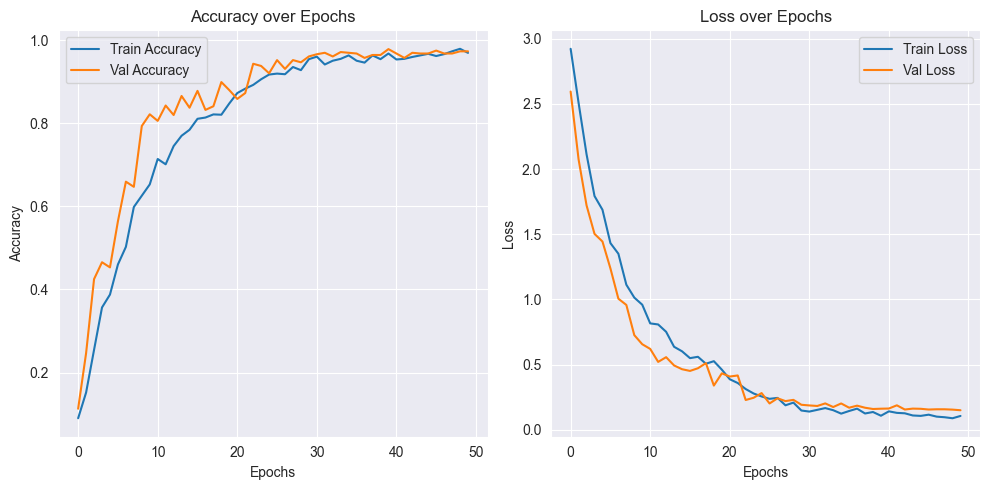

In [18]:
# Plot Training History
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

18/18 [==============================] - 0s 4ms/step
Confusion Matrix:
 [[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0 26  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 32  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 34  2  1  0  0  0  0  0]
 [ 0

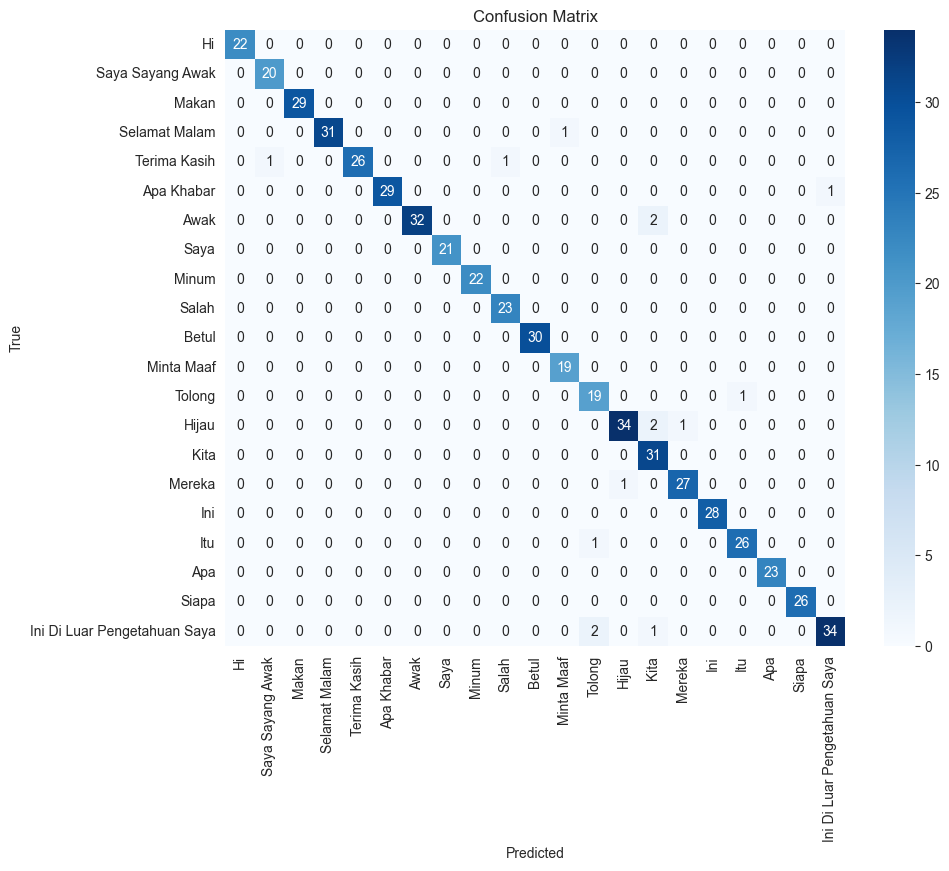

In [19]:
# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy Score:", accuracy)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIONS, yticklabels=ACTIONS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Model Name Declaration
model_codename = "video_model_CNN_LSTM_v11.keras"

In [21]:
#Save the model
model.save(model_codename)

In [25]:
# Test the model in real-time
def real_time_test(model):
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.3

    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process frame
            _, results = mediapipe_detection(frame, holistic)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-SEQUENCE_LENGTH:]
            
            # Predict action
            if len(sequence) == SEQUENCE_LENGTH:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(res)
                predictions.append(np.argmax(res))
                
                if res[np.argmax(res)] > threshold:
                    action = ACTIONS[np.argmax(res)]
                    sentence.append(action)

            # Display prediction
            # Assuming `frame` is the video frame
            frame_height, frame_width, _ = frame.shape  # Get the frame dimensions
            
            # Define rectangle at the bottom
            cv2.rectangle(frame, (0, frame_height - 40), (frame_width, frame_height), (255, 255, 255), -1)
            
            # Add text inside the rectangle
            cv2.putText(frame, ' '.join(sentence[-1:]), (10, frame_height - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (13, 13, 13), 2, cv2.LINE_AA)
            cv2.imshow("Sign Language Recognition", frame)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

model = tf.keras.models.load_model(model_codename)
real_time_test(model)

1/1 [==============================] - 0s 74ms/step
[9.9979764e-01 1.1247266e-04 3.1958738e-05 4.7793942e-11 7.0281961e-11
 2.3610129e-11 2.1312589e-09 4.7511203e-14 5.7907175e-05 7.2126041e-15
 1.1833425e-10 1.0716495e-10 5.1400529e-12 6.5045087e-11 2.4993298e-16
 5.0318338e-13 8.0364410e-11 7.5077997e-13 6.9492780e-09 7.9692621e-15
 2.8865650e-13]
1/1 [==============================] - 0s 19ms/step
[9.9982327e-01 1.0617980e-04 2.7585038e-05 3.7658886e-11 4.9402912e-11
 1.8634431e-11 1.6775715e-09 3.4008552e-14 4.2920081e-05 4.5439150e-15
 9.3573753e-11 8.0420136e-11 3.4935210e-12 4.1096682e-11 1.6133853e-16
 3.2853025e-13 5.5916383e-11 5.3916859e-13 5.3083693e-09 4.9785729e-15
 1.9636190e-13]
1/1 [==============================] - 0s 18ms/step
[9.99843240e-01 1.04238359e-04 2.25952390e-05 2.86948434e-11
 3.33320871e-11 1.46800072e-11 1.31114342e-09 2.39438206e-14
 2.98121777e-05 2.63698128e-15 7.37018016e-11 5.74043799e-11
 2.27158483e-12 2.52685858e-11 1.02176274e-16 2.11263705e-13


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Confusion Matrix:
 [[31  0  3  0  0  0]
 [ 0 22  1  0  0  0]
 [ 1  0 23  0  0  0]
 [ 0  0  0 26  0  0]
 [ 0  2  0  0 25  0]
 [ 0  0  0  0  1 27]]
Accuracy Score: 0.9506172839506173


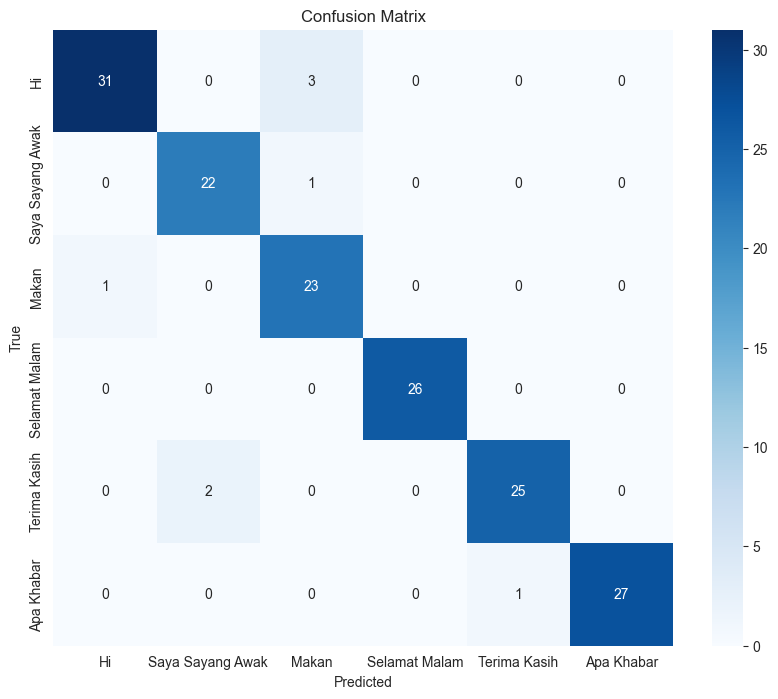

In [22]:
# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy Score:", accuracy)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIONS, yticklabels=ACTIONS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Combined X Train: (378, 90, 258), Combined X Test: (162, 90, 258), Combined Y Train: (378, 6), Combined Y Test: (162, 6)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │        49,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 7, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,536 (1021.62 KB)

 Trainable params: 187,232 (731.38 KB)

 Non-trainable params: 74,304 (290.25 KB)

Epoch 1/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - categorical_accuracy: 0.1811 - loss: 2.6055 - val_categorical_accuracy: 0.1728 - val_loss: 2.5512
Epoch 2/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.1556 - loss: 2.7300 - val_categorical_accuracy: 0.1728 - val_loss: 2.5155
Epoch 3/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.1664 - loss: 2.6710 - val_categorical_accuracy: 0.1728 - val_loss: 2.4799
Epoch 4/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.1305 - loss: 2.7249 - val_categorical_accuracy: 0.1728 - val_loss: 2.4443
Epoch 5/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.1756 - loss: 2.5793 - val_categorical_accuracy: 0.1728 - val_loss: 2.4093
Epoch 6/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.1541 - loss: 2.5114 - val_categorical_accuracy: 0.1728 - val_loss: 2.3744
Epoch 7/2000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.170

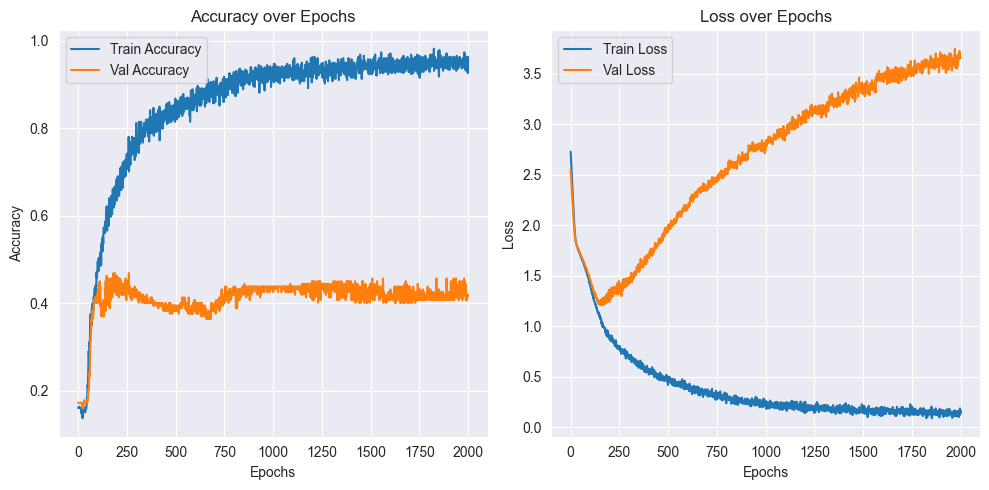

In [7]:
# Define the full set of actions (make sure these include all 6 actions)
ALL_ACTIONS = np.array(['Hi', 'Saya Sayang Awak', 'Makan',
                   'Selamat Malam', 'Terima Kasih', 'Apa Khabar'])

# Ensure both OLD_ACTIONS and NEW_ACTIONS are part of ALL_ACTIONS
OLD_ACTIONS = np.array(['Hi', 'Saya Sayang Awak', 'Makan'])
NEW_ACTIONS = np.array(['Selamat Malam', 'Terima Kasih', 'Apa Khabar'])

# Load data from path
def load_data_from_path(data_path, actions, no_sequences):
    sequences, labels = [], []
    label_map = {action: idx for idx, action in enumerate(ALL_ACTIONS)}  # Ensure all 6 actions are accounted for

    for action in actions:
        for sequence in range(no_sequences):
            npy_path = os.path.join(data_path, action, f"{sequence}.npy")
            keypoints = np.load(npy_path)
            sequences.append(keypoints)
            labels.append(label_map[action])

    x = np.array(sequences)
    y = to_categorical(labels, num_classes=6)  # Ensure that we have 6 classes
    return x, y

# Load data (ensure this covers all 6 classes)
x_old, y_old = load_data_from_path("DATA", OLD_ACTIONS, NO_SEQUENCES)
x_new, y_new = load_data_from_path("NEW_DATA", NEW_ACTIONS, NO_SEQUENCES)

# Normalize data
scaler = MinMaxScaler()
x_old_flat = x_old.reshape(-1, x_old.shape[-1])
x_new_flat = x_new.reshape(-1, x_new.shape[-1])
x_old_scaled = scaler.fit_transform(x_old_flat).reshape(x_old.shape)
x_new_scaled = scaler.transform(x_new_flat).reshape(x_new.shape)

# Combine datasets
x_combined = np.concatenate((x_old_scaled, x_new_scaled), axis=0)
y_combined = np.concatenate((y_old, y_new), axis=0)

# Apply SMOTE to balance the classes
x_combined_reshaped = x_combined.reshape(x_combined.shape[0], -1)
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_combined_reshaped, y_combined)

# Reshape the data back to the original shape
x_resampled = x_resampled.reshape(x_resampled.shape[0], x_combined.shape[1], x_combined.shape[2])

# Split the dataset into training and testing
x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(
    x_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Combined X Train: {x_train_combined.shape}, Combined X Test: {x_test_combined.shape}, Combined Y Train: {y_train_combined.shape}, Combined Y Test: {y_test_combined.shape}")

# Load pre-trained model
model_codename = "video_model_CNN_LSTM_v6.keras"
base_model = tf.keras.models.load_model(model_codename)

# Create a new Sequential model
model = Sequential(base_model.layers[:-1])  # Exclude the last Dense layer
model.add(Dense(6, activation='softmax', name='output_layer'))  # Add a new Dense layer for 6 classes

# Freeze layers for fine-tuning
for layer in model.layers[:-5]:  # Freeze all layers except the last 5
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])
model.summary()

# Fine-tune the model on the combined dataset
history = model.fit(
    x_train_combined, y_train_combined,
    validation_data=(x_test_combined, y_test_combined),
    epochs=2000,
    batch_size=32
)

# Plot Training History
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Model Output Shape: (162, 6)
Number of Classes (Expected): 6
Confusion Matrix:
 [[ 0 34  0  0  0  0]
 [ 0 20  0  0  0  3]
 [ 0 24  0  0  0  0]
 [ 0  0  0 20  0  6]
 [ 0 25  0  1  1  0]
 [ 0  1  0  0  0 27]]
Accuracy Score: 0.41975308641975306


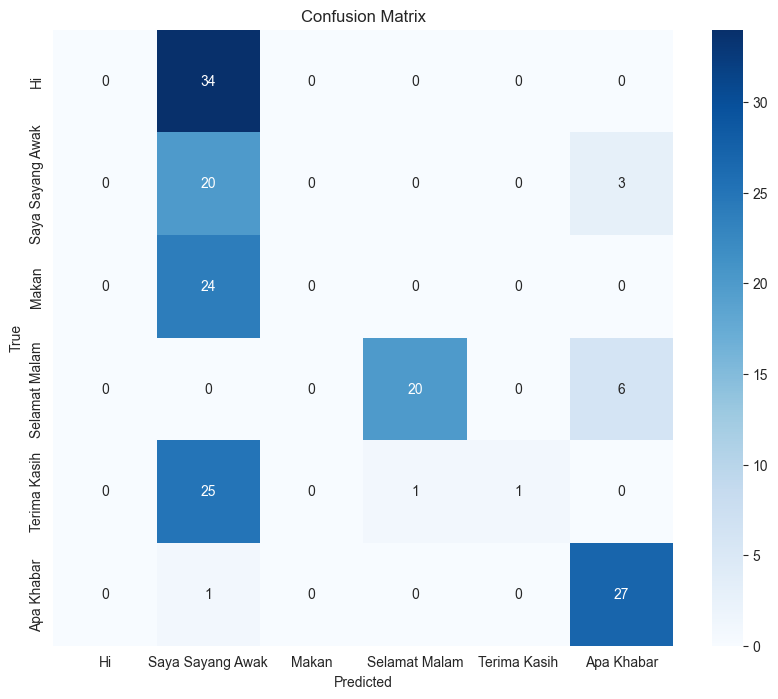

In [8]:
# Predict on test data
y_pred = model.predict(x_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_combined, axis=1)
print("Model Output Shape:", y_pred.shape)
print("Number of Classes (Expected):", len(ALL_ACTIONS))
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy Score:", accuracy)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=ALL_ACTIONS, yticklabels=ALL_ACTIONS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [37]:
#Save the model
model.save("video_model_CNN_LSTM_v6_fine_tuned.keras")